<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/MultilayerANNbatchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-2ce0d24443bf>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


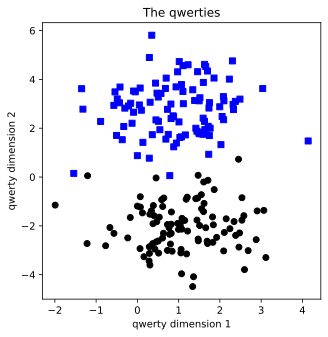

In [2]:
# data creation
nPerClust=100
blur=1

#data centre
A=[1,3]
B=[1,-2]
#generate data
a=[A[0]+np.random.randn(nPerClust)*blur,A[1]+np.random.randn(nPerClust)*blur]
b=[B[0]+np.random.randn(nPerClust)*blur,B[1]+np.random.randn(nPerClust)*blur]
#true labels
labels_np=np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
#concatanate
data_np=np.hstack((a,b)).T
#convert to a pytorch tensor
data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).float()
#show the data
fig=plt.figure(figsize=(5,5))
plt.plot(data[labels[:,0]==0,0],data[labels[:,0]==0,1],'bs')
plt.plot(data[labels[:,0]==1,0],data[labels[:,0]==1,1],'ko')
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()




In [3]:
#building a nn model
def createANNmodel(LearningRate):
  ANNclassify=nn.Sequential(
    nn.Linear(2,16), #input layer
    nn.ReLU(), #activation function
    nn.BatchNorm1d(16), #batch normalisation
    nn.Linear(16,1),#hidden layer
    nn.ReLU(),#activation function
    nn.Linear(1,1), #output unit
    nn.Sigmoid(),#final activation unit
    )
  #model parameters
  lossfun=nn.BCELoss()
  #optimizer (the flavour of gradient descent to implement)
  optimizer=torch.optim.SGD(ANNclassify.parameters(),lr=LearningRate)
  #model parameters
  return ANNclassify,lossfun,optimizer



In [4]:
# a function that train the model
numepochs=1000
def trainTheModel(ANNclassify):
  #initialize losses
  losses=torch.zeros(numepochs)
  #loop over epochs
  for epochi in range(numepochs):
    #forward pass
    yHat=ANNclassify(data)
    #compute loss
    loss=lossfun(yHat,labels)
    losses[epochi]=loss.item()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  #final forwardpass
  predictions=ANNclassify(data)
  #compute the predictions and report accuracy
  totalacc=100*torch.mean(((predictions>0.5)==labels).float())

  return losses,predictions,totalacc


Test the new code by running it once

final accuracy :98.5%


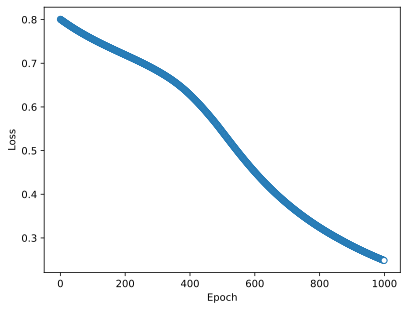

In [5]:
#manually compute losses
ANNclassify,lossfun,optimizer=createANNmodel(0.01)
#run it
losses,predictions,totalacc=trainTheModel(ANNclassify)
#report accuracy
print('final accuracy :%g%%'%totalacc)
#show the losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Experiment

In [6]:
#the set of learning rates to test
learningrates=np.linspace(0.001,0.1,40)
#initialize results output
accByLR=[]
allLosses=np.zeros((len(learningrates),numepochs))
#loop through learning rates
for i, lr in enumerate(learningrates):
  #create the model
  ANNclassify,lossfun,optimizer=createANNmodel(lr)
  #train the model
  losses,predictions,totalacc=trainTheModel(ANNclassify)
  #store the results
  accByLR.append(totalacc)
  allLosses[i,:]=losses.detach()


<ipython-input-6-4e1cdfc6529e>:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  allLosses[i,:]=losses.detach()


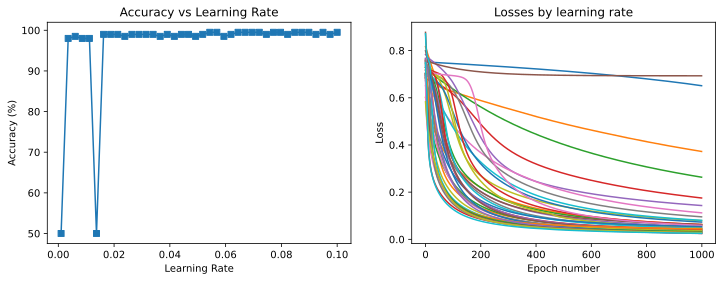

In [7]:
#plot the results
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy vs Learning Rate')
ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()


In [8]:
#PROPORTION OF RUNS WHERE THE MODEL HAD AT LEAST 70% ACCURACY
sum(torch.tensor(accByLR)>70)/len(accByLR)

tensor(0.9500)

Run a meta ecperiment to get more reliable results

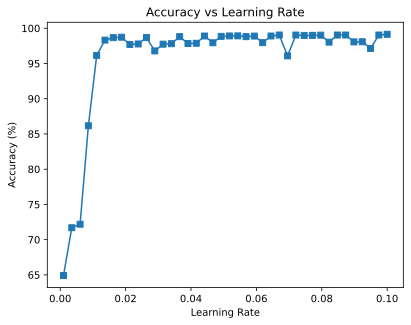

In [9]:
#run a 'meta-ecperiment' by repeating the experiment N times
#(different random weight initializations each time)
#number of times to iterate through the experiment
numExps=50
#matrix to store all results
accMeta=np.zeros((numExps,len(learningrates)))
#fewer epochs to reduce computation time
numepochs=500
#now for the experiment
for expi in range(numExps):
  #loop through learning rate
  for i, lr in enumerate(learningrates):
    #create the model
    ANNclassify,lossfun,optimizer=createANNmodel(lr)
    #train the model
    losses,predictions,totalacc=trainTheModel(ANNclassify)
    #store the results
    accMeta[expi,i]=totalacc
#plot the results, average over the experiments
plt.plot(learningrates,torch.mean(torch.tensor(accMeta),0),'s-')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Learning Rate')
plt.show()